##### 1. Измените функцию calc_logloss так, чтобы нули по возможности не попадали в np.log

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings('ignore')

Решил по аналогии с sklearn __заменять__ 0 и 1 на __максимально близкое__ к этим значениям число с плавающей запятой

In [2]:
def calc_logloss(y, y_pred):
    
    y_pred = y_pred.astype(float)
    
    for i in range(y_pred.shape[0]):
        if y_pred[i] <= 0:
            y_pred[i] = 0.0000000000000001
        elif y_pred[i] >= 1:
            y_pred[i] = 0.9999999999999999
                
    return - np.mean(y * np.log(y_pred) + (1.0 - y) * np.log(1.0 - y_pred))

__Проверяем__

In [3]:
y = np.array([1, 0])

y_pred1 = np.array([0, 1])
y_pred2 = np.array([1, 0])

calc_logloss(y, y_pred1), calc_logloss(y, y_pred2)

(36.78908102879092, 1.1102230246251565e-16)

##### 2. Подберите аргументы функции eval_model для логистической регрессии таким образом, чтобы log loss был минимальным.

__Генерируем датасет__

In [4]:
X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 1, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450,
               800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 
               1, 3, 3, 1, 2]], dtype = np.float64)

y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

__Стандартизируем выбоку__

In [5]:
def calc_std_feat(x):
    result = (x[1:].T - x[1:].mean(axis=1)) / x[1:].std(axis=1)
    x[1:] = result.T
    return x

In [6]:
standart_X = calc_std_feat(X)
standart_X

array([[ 1.        ,  1.        ,  1.        ,  1.        ,  1.        ,
         1.        ,  1.        ,  1.        ,  1.        ,  1.        ],
       [-0.57142857, -0.57142857, -0.21428571, -0.57142857,  0.14285714,
        -0.92857143,  0.85714286,  2.64285714, -0.57142857, -0.21428571],
       [-0.97958969, -0.56713087, -0.46401617, -0.77336028,  0.97958969,
        -0.36090146,  1.08270439,  2.11385144, -1.08270439,  0.05155735],
       [-0.89625816, -0.89625816,  0.38411064, -0.89625816,  0.38411064,
        -0.89625816,  1.66447944,  1.66447944, -0.89625816,  0.38411064]])

__Обучаем модель__

In [7]:
def sigmoid(z):
    res = 1 / (1 + np.exp(-z))
    return res

In [8]:
def eval_model(X, y, iterations, alpha=1e-4):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    errors = []
    ww = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T))
        
        errors.append(err)
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
    
    errors = np.array(errors)
    
    return errors, W

In [9]:
model = eval_model(
    X=standart_X,
    y=y,
    iterations=7000,
    alpha=1e-2
)

model[0][-2:]

700 [ 0.14826148 -1.02557519 -0.05632466  1.52387108] 0.4815067273816863
1400 [ 0.06429891 -1.31172363 -0.199022    1.94355308] 0.44020825317421464
2100 [ 0.06474145 -1.5357131  -0.31341477  2.30581809] 0.4123351656521385
2800 [ 0.08535996 -1.72283918 -0.41574631  2.61886104] 0.391734908077499
3500 [ 0.1117494  -1.88243902 -0.50944964  2.89447715] 0.3758656225109043
4200 [ 0.14010956 -2.02077465 -0.59658742  3.14097152] 0.3632368317911221
4900 [ 0.16919001 -2.14231108 -0.6785386   3.36432926] 0.35290935856149075
5600 [ 0.19846906 -2.25033852 -0.75626956  3.56897558] 0.34426685108822597
6300 [ 0.22768374 -2.34734401 -0.83048131  3.75825275] 0.3368910655429685
7000 [ 0.25668596 -2.43524671 -0.90169667  3.93473214] 0.33048980157040564


array([0.33049836, 0.3304898 ])

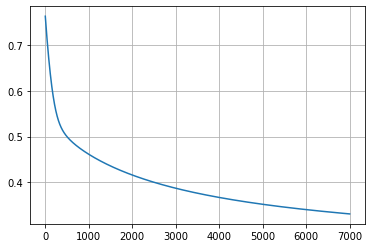

In [10]:
plt.plot(range(model[0].shape[0]),model[0])

plt.grid()
plt.show()

__log_loss__ минимален при __alpha = 1e-2__ и количестве __итераций = 6000__

##### 3. Создайте функцию calc_pred_proba, возвращающую предсказанную вероятность класса 1 (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred_proba).

In [11]:
def cals_pred_proba(W, X):
    
    y_pred_proba = 1 / (1 + np.exp(-np.dot(W, X)))
    
    return y_pred_proba

__Просматриваем результат__

In [12]:
cpp = cals_pred_proba(model[1], standart_X)
cpp

array([0.26992808, 0.20312112, 0.93751457, 0.23488253, 0.63108477,
       0.33556405, 0.97685007, 0.17710363, 0.28863775, 0.9040804 ])

##### 4. Создайте функцию calc_pred, возвращающую предсказанный класс (на вход подаются W, который уже посчитан функцией eval_model и X, на выходе - массив y_pred).

In [13]:
def y_pred(W, X):
    
    y_pred = cals_pred_proba(W, X)

    for i in range(y_pred.shape[0]):
        if y_pred[i] > 0.5:
            y_pred[i] = 1
        else:
            y_pred[i] = 0
    
    return y_pred

__Просматриваем результат__

In [14]:
cp = y_pred(model[1], standart_X)
cp

array([0., 0., 1., 0., 1., 0., 1., 0., 0., 1.])

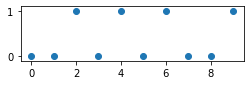

In [15]:
plt.figure(figsize=(4,1))
plt.scatter(range(cp.shape[0]), cp)
plt.show()

##### 5. Посчитайте Accuracy, матрицу ошибок, точность и полноту, а также F1 score.

__Accuracy__

In [16]:
def accuracy(y, y_pred):
    
    acc = (y_pred == y).sum()/cp.shape[0]
    
    return acc

In [17]:
accuracy(y=y, y_pred=cp)

0.9

__Матрица ошибок__

In [18]:
def error_matrix(y, y_pred):
    
    TP = y * y_pred
    FP = y_pred - TP
    FN = y - TP
    TN = y**0 - TP - FP - FN
    
    return np.array([[TP.sum(), FP.sum()], 
                     [FN.sum(), TN.sum()]])

In [19]:
em = error_matrix(y=y, y_pred=cp)
em

array([[4., 0.],
       [1., 5.]])

__точность__

In [20]:
def precision(em):
    return em[0,0]/(em[0,0]+em[0,1])

In [21]:
precision(em)

1.0

__полнота__

In [22]:
def recall(em):
    return em[0,0]/(em[0,0]+em[1,0])

In [23]:
recall(em)

0.8

__F1 score__

In [24]:
def F1_score(em):
    pre = precision(em)
    rec = recall(em)
    return (2*pre*rec)/(pre+rec)

In [25]:
F1_score(em)

0.888888888888889

##### 6. Могла ли модель переобучиться? Почему?

Модель может переобучиться потому, что: 
- мы оценили приблизительное количество итераций
- так же небыло использовано  минимальное значение
- в исходной матрице малое количество объектов, из за чего обучение происходит быстрее
- не были использовани $L_1$ или $L_2$ регуляции

##### 7*. Создайте функции eval_model_l1 и eval_model_l2 с применением L1 и L2 регуляризаций соответственно.

In [26]:
def eval_model_l1(X, y, iterations, lambda_, alpha=1e-4):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    errors = []
    ww = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + (lambda_/2)*np.sum(np.abs(W))) # <- l1
        
        errors.append(err)
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
    
    errors = np.array(errors)
    
    return errors, W

Попробуем обучить модель с __$L_1$__ регуляцией

In [27]:
model_l1 = eval_model_l1(
    X=standart_X,
    y=y,
    iterations=6000,
    alpha=1e-2,
    lambda_=1e-2
)

model_l1[0][-2:]

600 [ 0.13121443 -0.99127805 -0.04628782  1.44011413] 0.48843673899885187
1200 [ 0.00760053 -1.26152174 -0.18672605  1.79411429] 0.45146683053684394
1800 [-0.02726861 -1.47378681 -0.29520216  2.10777015] 0.4260525042359725
2400 [-0.03859122 -1.65579393 -0.39229656  2.37854407] 0.4070894418042199
3000 [-0.0428402  -1.81492155 -0.48057542  2.61543606] 0.39253816904557737
3600 [-0.0449765  -1.95635009 -0.56166541  2.82504117] 0.3811592941717158
4200 [-0.04671431 -2.08387936 -0.63667682  3.01231542] 0.3721296713651229
4800 [-0.0487469  -2.20037916 -0.70641217  3.18105732] 0.3648854742460782
5400 [-0.05140369 -2.30806828 -0.77147958  3.3342269 ] 0.35903151283107737
6000 [-0.05486487 -2.40869622 -0.8323577   3.47416581] 0.35428491350016966


array([0.35429203, 0.35428491])

Просмотрим результат на графике

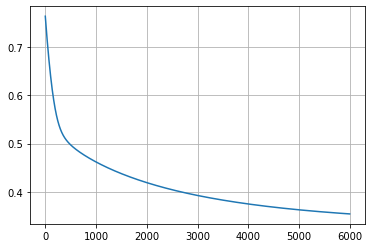

In [28]:
plt.plot(range(model_l1[0].shape[0]),model_l1[0])

plt.grid()
plt.show()

Видно что с добавлением количества итераций увеличивается ошибка

In [29]:
def eval_model_l2(X, y, iterations, lambda_, alpha=1e-4):
    
    np.random.seed(42)
    W = np.random.randn(X.shape[0])
    n = X.shape[1]
    errors = []
    ww = []
    
    for i in range(1, iterations+1):
        z = np.dot(W, X)
        y_pred = sigmoid(z)
        err = calc_logloss(y, y_pred)
        W -= alpha * (1/n * np.dot((y_pred - y), X.T) + (lambda_/2)*np.sum(W**2)) # <- l2
        
        errors.append(err)
        
        if i % (iterations / 10) == 0:
            print(i, W, err)
    
    errors = np.array(errors)
    
    return errors, W

Теперь обучим модель с __$L_2$__ регуляцией

In [30]:
model_l2 = eval_model_l2(
    X=standart_X,
    y=y,
    iterations=6000,
    alpha=1e-2,
    lambda_=1e-2
)

model_l2[0][-2:]

600 [ 0.12935694 -0.99307875 -0.04809914  1.4383329 ] 0.4884012302575327
1200 [-0.01267031 -1.27203528 -0.19725162  1.7820695 ] 0.45233911948021605
1800 [-0.07585717 -1.49655503 -0.31673895  2.08065684] 0.42905957004441786
2400 [-0.12378339 -1.69635925 -0.42714398  2.33142063] 0.4135579719731043
3000 [-0.17353968 -1.8816224  -0.53119934  2.54347432] 0.4040994481372596
3600 [-0.23086955 -2.06092315 -0.63070031  2.72410528] 0.39983349748503866
4200 [-0.29884885 -2.24230814 -0.72723064  2.87930116] 0.40044261363937583
4800 [-0.38006431 -2.43356681 -0.82229067  3.01438398] 0.40600340537184393
5400 [-0.47705525 -2.64220236 -0.91731532  3.1345529 ] 0.4169009921777299
6000 [-0.59230376 -2.87529328 -1.01376011  3.24528445] 0.43379912629628087


array([0.43376547, 0.43379913])

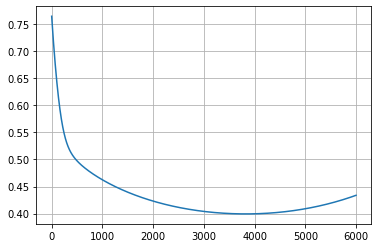

In [31]:
plt.plot(range(model_l2[0].shape[0]),model_l2[0])

plt.grid()
plt.show()

В сравнении с $L_1$, $L_2$ добавляет меньшую ошибку